In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Basic convolutional neural network
import keras_tuner as kt
from keras_tuner import BayesianOptimization
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import os, numpy as np, time
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt

In [3]:
def hms(start, end):
    seconds = end-start
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return h,m,s

In [4]:
img_size = 224
# Basic Covnet CNN
def create_model(hp):
    learning_rate = hp.Choice('learning_rate', values = [0.000001, 0.00001, 0.0001], default = 0.000001)
    dropout_rate = hp.Float('dropout', 0.2, 0.8, step=0.1)
    neurons = hp.Choice('neurons', values = [256, 512, 1024, 2048], default = 256)
    dense_layers = hp.Int('dense_layers', 0, 2, default = 0)
    #pooling = hp.Choice("global_pooling", ["flatten", "avg"], default = 'flatten')
    
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    #### Fully-Connected Layer ####
    # Choose top model pooling layer.
#     if pooling == "avg":
#         model.add(GlobalAveragePooling2D())
#         for dl in range(dense_layers):
#             model.add(Dense(neurons, activation='relu'))
#             model.add(Dropout(dropout_rate))
#     else:
    model.add(Flatten())
    for dl in range(dense_layers):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    # Add final softmax layer for predictions
    model.add(Dense(5, activation='softmax'))
    
    # Compiles the model for training.
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
train_data_dir = 'cropped_resized_imgs/train'
test_data_dir = 'cropped_resized_imgs/test'
class_subset = sorted(os.listdir(train_data_dir))

BATCH_SIZE = 128
totalstart = time.time()
modelName = 'BaseCNN'
filename = 'BaseCNN_HP_Results.txt'

# create image generators with data augmentation
train_generator = ImageDataGenerator(
    rescale=1./255,              # normalize pixel values between 0-1
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,           # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)

traingen = train_generator.flow_from_directory(train_data_dir,
                                                target_size=(img_size, img_size),
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                classes=class_subset,
                                                subset='training',
                                                shuffle=True,
                                                seed=55)

validgen = train_generator.flow_from_directory(train_data_dir,
                                                target_size=(img_size, img_size),
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                classes=class_subset,
                                                subset='validation',
                                                shuffle=True,
                                                seed=55)

test_generator = ImageDataGenerator(rescale=1./255)
testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(img_size, img_size),
                                             batch_size=1,
                                             class_mode=None,
                                             shuffle=False,
                                             seed=55)
# set values
n_epochs = 50
max_trial_epochs = 40
max_trials = 35
n_steps = traingen.samples / BATCH_SIZE
n_val_steps = validgen.samples / BATCH_SIZE

tuner = BayesianOptimization(create_model,
                            objective='val_accuracy',
                            max_trials=max_trials,
                            directory='hp_models',
                            project_name=modelName,
                            overwrite=True,
                            seed=55)

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True)

tuner.search(traingen,
            batch_size=BATCH_SIZE,
            epochs=max_trial_epochs,
            validation_data=validgen,
            steps_per_epoch=n_steps,
            validation_steps=n_val_steps,
            callbacks=[early_stop],
            workers=16,
            verbose=1)

# print and save tuner results
best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)

best_model = tuner.get_best_models(num_models=1)
print(best_model[0].summary())

print(tuner.results_summary(num_trials=max_trials))

with open(filename, 'w') as f:
    f.write('Best hyperparameters: {}\n\nBest Model Summary\n'.format(best_hp.values))
    best_model[0].summary(print_fn=lambda x: f.write(x + '\n'))

# ************************************************************************************************************
# train full model with hyperparameters

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='weights/{}.hp.weights.hdf5'.format(modelName),
                                  save_best_only=True,
                                  verbose=1)

# load and train model from hyperparameters
bestTunedModel = tuner.hypermodel.build(best_hp)
history = bestTunedModel.fit(traingen,
                    batch_size=BATCH_SIZE,
                    epochs=n_epochs,
                    validation_data=validgen,
                    steps_per_epoch=n_steps,
                    validation_steps=n_val_steps,
                    callbacks=[tl_checkpoint_1],
                    workers=16,
                    verbose=1)

# load model weights
bestTunedModel.load_weights('weights/{}.hp.weights.hdf5'.format(modelName)) # initialize the best trained weights
# get labels
labels = traingen.class_indices
labels = dict((v,k) for k,v in labels.items())

# Generate predictions
testgen.reset()
predstart = time.time()
preds = bestTunedModel.predict(testgen)
pred_classes = np.argmax(preds, axis=1)
true_classes = testgen.classes
acc = accuracy_score(true_classes, pred_classes)
predend = time.time()
avgPredictionTime = (predend - predstart)/1200

print("Best Base Model Accuracy: {:.2f}%".format(acc * 100))

# save history object to disk
with open('modelrun_history/{}.hp.history'.format(modelName), 'wb') as histfile:
    pickle.dump(history.history, histfile)

# save model accuracy to file
with open(filename, 'a') as f:
    f.write("Model Accuracy: {:.2f}%\n".format(acc * 100))
    f.write("Average prediction time per image: {} seconds\n".format(avgPredictionTime))

# total modeling time
totalEnd = time.time()
totalT=hms(totalstart, totalEnd)
print("Average prediction time per image: {} seconds\n".format(avgPredictionTime))
print('Total runtime is {:.0f} hours, {:.0f} minutes, {:.1f} seconds'.format(totalT[0],totalT[1],totalT[2]))
with open(filename, 'a') as f:
    f.write('Total runtime is {:.0f} hours, {:.0f} minutes, {:.1f} seconds'.format(totalT[0],totalT[1],totalT[2]))

Trial 35 Complete [00h 04m 46s]
val_accuracy: 0.6069444417953491

Best val_accuracy So Far: 0.6611111164093018
Total elapsed time: 01h 54m 05s
INFO:tensorflow:Oracle triggered exit
{'learning_rate': 0.0001, 'dropout': 0.8000000000000003, 'neurons': 256, 'dense_layers': 2}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)

31/31 [==============================] - 10s 251ms/step - loss: 1.5933 - accuracy: 0.2289 - val_loss: 1.5394 - val_accuracy: 0.4569

Epoch 00005: val_loss improved from 1.57572 to 1.53942, saving model to weights\BaseCNN.hp.weights.hdf5
Epoch 6/50
31/31 [==============================] - 10s 251ms/step - loss: 1.5718 - accuracy: 0.2591 - val_loss: 1.5124 - val_accuracy: 0.5139

Epoch 00006: val_loss improved from 1.53942 to 1.51244, saving model to weights\BaseCNN.hp.weights.hdf5
Epoch 7/50
31/31 [==============================] - 10s 258ms/step - loss: 1.5473 - accuracy: 0.2672 - val_loss: 1.4472 - val_accuracy: 0.4764

Epoch 00007: val_loss improved from 1.51244 to 1.44717, saving model to weights\BaseCNN.hp.weights.hdf5
Epoch 8/50
31/31 [==============================] - 10s 251ms/step - loss: 1.5105 - accuracy: 0.3005 - val_loss: 1.3956 - val_accuracy: 0.4944

Epoch 00008: val_loss improved from 1.44717 to 1.39558, saving model to weights\BaseCNN.hp.weights.hdf5
Epoch 9/50
31/31 [=

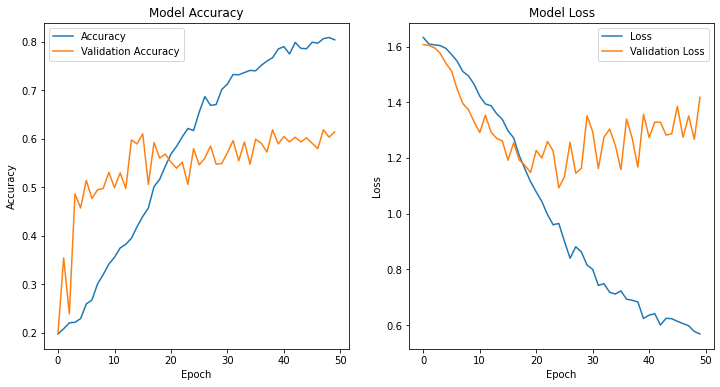

In [6]:
# plot training/validation accuracy and loss
plt.figure(figsize=(12, 6)) # figsize(width, height) in inches, dpi=100
# plot accuracy
plt.subplot(1, 2, 1) # (rows, cols, index)
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.subplot(1, 2, 2) # (rows, cols, index)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss", "Validation Loss"])

Found 1200 images belonging to 5 classes.
0.7175


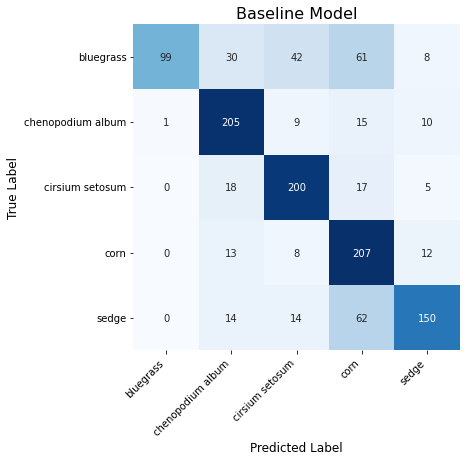

In [7]:
from keras.models import load_model
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

test_data_dir = 'cropped_resized_imgs/test'
img_size = 224

# function to create heatmap
def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

# create test generator
test_generator = ImageDataGenerator(rescale=1./255)
testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(img_size, img_size),
                                             batch_size=1,
                                             class_mode=None,
                                             shuffle=False,
                                             seed=55)
# Get the names of the classes
class_names = testgen.class_indices.keys()

# load model
bestModel = load_model('weights/BaseCNN.hp.weights.hdf5')

# Generate predictions
testgen.reset()
preds = bestModel.predict(testgen)
pred_classes = np.argmax(preds, axis=1)
true_classes = testgen.classes
acc = accuracy_score(true_classes, pred_classes)
print(acc)

# plot confusion matrix
plt.figure(figsize=(12, 6)) # figsize(width, height) in inches, dpi=100
ax = plt.subplot(1, 1, 1) # (rows, cols, index)
plot_heatmap(true_classes, pred_classes, class_names, ax, title="Baseline Model")

In [ ]:
history = pickle.load(open('modelrun_history/baseCNN.doTrue.512nodes.lr0.0001_history', "rb"))
plt.figure(figsize=(12, 6)) # figsize(width, height) in inches, dpi=100
# plot accuracy
plt.subplot(1, 2, 1) # (rows, cols, index)
for k,v in history.items():
    if k=="accuracy":
        plt.plot(v)
    if k=="val_accuracy":
        plt.plot(v)
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy"])


# plot loss
plt.subplot(1, 2, 2) # (rows, cols, index)
for k,v in history.items():
    if k=="loss":
        plt.plot(v)
    if k=="val_loss":
        plt.plot(v)
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss", "Validation Loss"])


# fit model to images
BATCH_SIZE = 120
train_data_dir = 'cropped_resized_imgs/train'
test_data_dir = 'cropped_resized_imgs/test'
class_subset = sorted(os.listdir(train_data_dir))

# create image generators with data augmentation
train_generator = ImageDataGenerator(
    rescale=1./255,              # normalize pixel values between 0-1
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,           # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)

traingen = train_generator.flow_from_directory(train_data_dir,
                                                target_size=(img_size, img_size),
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                classes=class_subset,
                                                subset='training',
                                                shuffle=True,
                                                seed=55)

validgen = train_generator.flow_from_directory(train_data_dir,
                                                target_size=(img_size, img_size),
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                classes=class_subset,
                                                subset='validation',
                                                shuffle=True,
                                                seed=55)

test_generator = ImageDataGenerator(rescale=1./255)
testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(img_size, img_size),
                                             batch_size=1,
                                             class_mode=None,
                                             shuffle=False,
                                             seed=55)

history = pickle.load(open('/trainHistoryDict'), "rb")

# Basic Covnet CNN
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.summary()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

display_results(true_classes, predicted_classes, class_indices.values())
plot_predictions(true_classes, predicted_classes, testgen, class_indices)